In [6]:
import numpy as np
from glob import glob
import cv2                
import matplotlib.pyplot as plt   
from tqdm import tqdm_notebook as tqdm
import torch
import torchvision.models as models
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import torch.optim as optim
import torch.nn.functional as F
import os
from torchvision import datasets
import torchvision.transforms as transforms
%matplotlib inline

ImageFile.LOAD_TRUNCATED_IMAGES = True
# check if CUDA is available
use_cuda = torch.cuda.is_available()

# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [23]:
# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


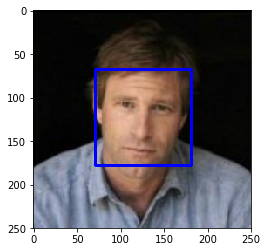

In [24]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [25]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [26]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

# Set a counter for detected human faces
count = 0

# Loop through list and check if faces are detected
for path in tqdm(human_files_short):
    if face_detector(path):
        count += 1

print('Using OpenCV CascadeClassifier {}% of the first 100 images in human_files have a detected human face'.format(count))

# Reset counter
count = 0

# Loop through list and check if faces are detected
for path in tqdm(dog_files_short):
    if face_detector(path):
        count+=1

print('Using OpenCV CascadeClassifier {}% of the first 100 images in dog_files have a detected human face'.format(count))



Using OpenCV CascadeClassifier 96% of the first 100 images in human_files have a detected human face



Using OpenCV CascadeClassifier 18% of the first 100 images in dog_files have a detected human face


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [6]:
### (Optional) 
### TODO: Test performance of another face detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [27]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

In [28]:
# Incase we need to delete a model from memory
# del VGG16
# torch._C._cuda_emptyCache()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [29]:
def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    # Sets the module in evaluation mode
    VGG16.eval()
    
    # All pre-trained models expect input images normalized in the same way, 
    # i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), 
    # where H and W are expected to be at least 224. 
    # The images have to be loaded in to a range of [0, 1] and 
    # then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]
    # Referenced from: https://pytorch.org/docs/stable/torchvision/models.html
    
    transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], 
                                 [0.229, 0.224, 0.225])
            ])
    image = Image.open(img_path)
    img_tensor = transform(image)
    prediction  = VGG16(img_tensor.cuda().unsqueeze(0))
    
    return torch.argmax(prediction).item()

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [30]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    
    # According to the dictionary of labels and information provided above:
    # Labels for corresponding to dogs go from keys 151-268
    if (VGG16_predict(img_path) >= 151 and VGG16_predict(img_path) <= 268):
        return True
    else:
        return False

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [31]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.


human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

# Set a counter for detected human faces
count = 0

# Loop through list and check if faces are detected
for path in tqdm(human_files_short):
    if dog_detector(path):
        count += 1

print('Using VGG16 (as is) {}% of the first 100 images in human_files have a detected dog'.format(count))

# Reset counter
count = 0

# Loop through list and check if faces are detected
for path in tqdm(dog_files_short):
    if dog_detector(path):
        count+=1

print('Using VGG16 (as is) {}% of the first 100 images in dog_files have a detected dog'.format(count))


Using VGG16 (as is) 0% of the first 100 images in human_files have a detected dog



Using VGG16 (as is) 93% of the first 100 images in dog_files have a detected dog


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [12]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [7]:
%matplotlib inline
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# Directory paths to all data (train, valid and test)
data_dir = 'dogImages/'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')

# All pre-trained models expect input images normalized in the same way, 
# i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), 
# where H and W are expected to be at least 224. 
# The images have to be loaded in to a range of [0, 1] and 
# then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]
# Referenced from: https://pytorch.org/docs/stable/torchvision/models.html
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
    ])

# We do similar tranformations to validation except Random flips and rotations
valid_test_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
    ])

In [8]:
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_test_transform)
test_data = datasets.ImageFolder(test_dir, transform=valid_test_transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(valid_data, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32)

print('Number of training images: {}'.format(len(train_data)))
print('Number of validation images: {}'.format(len(valid_data)))
print('Number of testing images: {}'.format(len(test_data)))

Number of training images: 6680
Number of validation images: 835
Number of testing images: 836


**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:
* In this exercise, I have gone for Random Resized-Crop where the size was decided based on the pre-trained models used. Usually its 224*224*3 (except inception V3, where its 229*229*3)
* Similar to the lessons, where we experimented with cifar data, I have augmented the data with Random Horizontal Flips and Random Rotations. I have also made sure that the data augmentation is not applied to validation dataset.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [15]:
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        # Convolutional layer: 224*224*3
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding = 2)
        # Convolutional layer: 112*112*16
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding = 2)
        # Convolutional layer: 56*56*32
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding = 1)
        # Convolutional layer: 28*28*64
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding = 1)
        # Max Pooling Layer
        self.pool =  nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully Connected Linear Layer: 14*14*128
        self.fc1 = nn.Linear(14*14*128, 1024)
        # Fully Connected Linear Layer: 1024 --> 512
        self.fc2 = nn.Linear(1024, 512)
        # Fully Connected Output Linear Layer: 512 --> 133
        self.output = nn.Linear(512, 133)
        # Dropout layer with probability of 0.25
        self.drop = nn.Dropout(0.25)
        
    def forward(self, x):
        ## Define forward behavior
        # Adding sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        # Flatten image input
        x = x.view(-1, 14*14*128)
        # Fully connected layers with relu activation function and dropout layer
        x = F.relu(self.fc1(self.drop(x)))
        x = F.relu(self.fc2(self.drop(x)))
        # Output layer
        x = self.output(x)
        
        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [16]:
print(model_scratch)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=133, bias=True)
  (drop): Dropout(p=0.25)
)


__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 
I have tried solving the problem with similar architecture of that we used when working with cifar dataset.  
All the layers except the output layer will have an activation function of ReLU, it has been proven to work the best for image data.
* We start with a CNN layer of 224x224x3 and output will be applied through a Max Pooling layer (2x2) which will yield 112x112x16. The purpose of Max Pooling is to avoind overfitting.
* Next we continue building CNN layer with input of 112x112x16 and its output goes through another pooling layer (2x2) and the output is of dimension: 56x56x32
* Next we continue building CNN layer with input og 56x56x32 and its output goes through another pooling layer (2x2) and the output is of dimension: 28x28x64. In the exercise with cifar, we stoped at 3 CNN layers, which I tried for this step as well, but the resultant model didnt satisfy the requirement. Hence we go for another CNN layer with Max Pooling after that.
* Lastly, we continue building CNN layer with input of 28x28x64 and its output goes through another pooling layer (2x2) and the output is of dimension: 14x14x128
* These CNN layers should be able to get the spatial combinations with respect to images, now we use fully connected layers to use combinations and classify the images based on these  
With respect to fully connected layers, since the number of output dimensions from CNN is so high, I deemed it safe to reduce it in dimensions slowly (using 3 fully connected layers)
* Fully connected linear layer which goes from 14x14x128 to 1024
* Fully connected linear layer which goes from 1024 to 512
* Fully connected linear layer which goes from 512 to 133 (number of output classifications)

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [17]:
### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.0005)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [9]:
# The following import is required for training to be robust to truncated images

# Keep a track of losses, for plotting
losses = {'train':[], 'validation':[]}

# Train function has been referenced from the function we used in cifar exercise.
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in tqdm(range(1, n_epochs+1)):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(tqdm(loaders['train'])):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            optimizer.zero_grad()
            
            pred = model(data)
            
            loss = criterion(pred, target)
            
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            loss.backward()
            optimizer.step()            
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(tqdm(loaders['valid'])):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            val_pred = model(data)
            val_loss = criterion(val_pred, target)
            
            valid_loss += ((1 / (batch_idx + 1)) * (val_loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if (valid_loss < valid_loss_min):
            print("Saving model.  Validation loss:... {} --> {}".format(valid_loss_min, valid_loss.item()))
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), save_path)
            print()
            
        losses['train'].append(train_loss)
        losses['validation'].append(valid_loss)
    # return trained model
    return model

In [19]:
loaders_scratch = {'train': train_loader, 'valid': val_loader, 'test': test_loader}
# train the model
model_scratch = train(100, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 4.861232 	Validation Loss: 4.760644
Saving model.  Validation loss:... inf --> 4.76064395904541



Epoch: 2 	Training Loss: 4.623065 	Validation Loss: 4.575727
Saving model.  Validation loss:... 4.76064395904541 --> 4.575727462768555



Epoch: 3 	Training Loss: 4.487152 	Validation Loss: 4.487165
Saving model.  Validation loss:... 4.575727462768555 --> 4.4871649742126465



Epoch: 4 	Training Loss: 4.394853 	Validation Loss: 4.355199
Saving model.  Validation loss:... 4.4871649742126465 --> 4.355199337005615



Epoch: 5 	Training Loss: 4.275178 	Validation Loss: 4.298306
Saving model.  Validation loss:... 4.355199337005615 --> 4.298305988311768



Epoch: 6 	Training Loss: 4.204925 	Validation Loss: 4.254631
Saving model.  Validation loss:... 4.298305988311768 --> 4.2546305656433105



Epoch: 7 	Training Loss: 4.134614 	Validation Loss: 4.260803


Epoch: 8 	Training Loss: 4.051361 	Validation Loss: 4.135923
Saving model.  Validation loss:... 4.2546305656433105 --> 4.135923385620117



Epoch: 9 	Training Loss: 3.975198 	Validation Loss: 4.050857
Saving model.  Validation loss:... 4.135923385620117 --> 4.050856590270996



Epoch: 10 	Training Loss: 3.932986 	Validation Loss: 4.092369


Epoch: 11 	Training Loss: 3.858711 	Validation Loss: 4.001476
Saving model.  Validation loss:... 4.050856590270996 --> 4.001475811004639



Epoch: 12 	Training Loss: 3.822865 	Validation Loss: 3.911726
Saving model.  Validation loss:... 4.001475811004639 --> 3.911726474761963



Epoch: 13 	Training Loss: 3.761929 	Validation Loss: 3.847424
Saving model.  Validation loss:... 3.911726474761963 --> 3.847424030303955



Epoch: 14 	Training Loss: 3.691639 	Validation Loss: 3.878154


Epoch: 15 	Training Loss: 3.642628 	Validation Loss: 3.741398
Saving model.  Validation loss:... 3.847424030303955 --> 3.7413976192474365



Epoch: 16 	Training Loss: 3.593316 	Validation Loss: 3.723724
Saving model.  Validation loss:... 3.7413976192474365 --> 3.723723888397217



Epoch: 17 	Training Loss: 3.525280 	Validation Loss: 3.732136


Epoch: 18 	Training Loss: 3.506056 	Validation Loss: 3.737666


Epoch: 19 	Training Loss: 3.444549 	Validation Loss: 3.709209
Saving model.  Validation loss:... 3.723723888397217 --> 3.7092087268829346



Epoch: 20 	Training Loss: 3.390083 	Validation Loss: 3.703881
Saving model.  Validation loss:... 3.7092087268829346 --> 3.703880548477173



Epoch: 21 	Training Loss: 3.380883 	Validation Loss: 3.708970


Epoch: 22 	Training Loss: 3.306958 	Validation Loss: 3.630352
Saving model.  Validation loss:... 3.703880548477173 --> 3.6303517818450928



Epoch: 23 	Training Loss: 3.282663 	Validation Loss: 3.734396


Epoch: 24 	Training Loss: 3.235498 	Validation Loss: 3.531923
Saving model.  Validation loss:... 3.6303517818450928 --> 3.5319228172302246



Epoch: 25 	Training Loss: 3.193410 	Validation Loss: 3.678320


Epoch: 26 	Training Loss: 3.197357 	Validation Loss: 3.553918


Epoch: 27 	Training Loss: 3.114769 	Validation Loss: 3.695872


Epoch: 28 	Training Loss: 3.110499 	Validation Loss: 3.534365


Epoch: 29 	Training Loss: 3.051147 	Validation Loss: 3.573963


Epoch: 30 	Training Loss: 3.071497 	Validation Loss: 3.455697
Saving model.  Validation loss:... 3.5319228172302246 --> 3.4556968212127686



Epoch: 31 	Training Loss: 2.986593 	Validation Loss: 3.512104


Epoch: 32 	Training Loss: 2.979785 	Validation Loss: 3.458657


Epoch: 33 	Training Loss: 2.957669 	Validation Loss: 3.416425
Saving model.  Validation loss:... 3.4556968212127686 --> 3.4164252281188965



Epoch: 34 	Training Loss: 2.918618 	Validation Loss: 3.524504


Epoch: 35 	Training Loss: 2.925126 	Validation Loss: 3.700958


Epoch: 36 	Training Loss: 2.887022 	Validation Loss: 3.389446
Saving model.  Validation loss:... 3.4164252281188965 --> 3.389446496963501



Epoch: 37 	Training Loss: 2.845260 	Validation Loss: 3.527379


Epoch: 38 	Training Loss: 2.845614 	Validation Loss: 3.495581


Epoch: 39 	Training Loss: 2.812990 	Validation Loss: 3.590113


Epoch: 40 	Training Loss: 2.816963 	Validation Loss: 3.433957


Epoch: 41 	Training Loss: 2.731410 	Validation Loss: 3.403704


Epoch: 42 	Training Loss: 2.757770 	Validation Loss: 3.455068


Epoch: 43 	Training Loss: 2.715586 	Validation Loss: 3.306987
Saving model.  Validation loss:... 3.389446496963501 --> 3.3069870471954346



Epoch: 44 	Training Loss: 2.700771 	Validation Loss: 3.410816


Epoch: 45 	Training Loss: 2.690118 	Validation Loss: 3.518550


Epoch: 46 	Training Loss: 2.632886 	Validation Loss: 3.501722


Epoch: 47 	Training Loss: 2.601708 	Validation Loss: 3.467206


Epoch: 48 	Training Loss: 2.603188 	Validation Loss: 3.443172


Epoch: 49 	Training Loss: 2.608091 	Validation Loss: 3.330869


Epoch: 50 	Training Loss: 2.578389 	Validation Loss: 3.362357


Epoch: 51 	Training Loss: 2.549857 	Validation Loss: 3.447021


Epoch: 52 	Training Loss: 2.528616 	Validation Loss: 3.410420


Epoch: 53 	Training Loss: 2.524980 	Validation Loss: 3.475863


Epoch: 54 	Training Loss: 2.502959 	Validation Loss: 3.400651


Epoch: 55 	Training Loss: 2.497294 	Validation Loss: 3.440863


Epoch: 56 	Training Loss: 2.471241 	Validation Loss: 3.489157


Epoch: 57 	Training Loss: 2.408560 	Validation Loss: 3.468277


Epoch: 58 	Training Loss: 2.401964 	Validation Loss: 3.470048


Epoch: 59 	Training Loss: 2.418268 	Validation Loss: 3.466808


Epoch: 60 	Training Loss: 2.399427 	Validation Loss: 3.463806


Epoch: 61 	Training Loss: 2.384606 	Validation Loss: 3.485923


Epoch: 62 	Training Loss: 2.365375 	Validation Loss: 3.512599


Epoch: 63 	Training Loss: 2.384784 	Validation Loss: 3.521895


Epoch: 64 	Training Loss: 2.289559 	Validation Loss: 3.434673


Epoch: 65 	Training Loss: 2.292772 	Validation Loss: 3.557019


Epoch: 66 	Training Loss: 2.342284 	Validation Loss: 3.419734


Epoch: 67 	Training Loss: 2.292103 	Validation Loss: 3.509070


Epoch: 68 	Training Loss: 2.258028 	Validation Loss: 3.416411


Epoch: 69 	Training Loss: 2.253504 	Validation Loss: 3.488187


Epoch: 70 	Training Loss: 2.260613 	Validation Loss: 3.457767


Epoch: 71 	Training Loss: 2.242664 	Validation Loss: 3.560403


Epoch: 72 	Training Loss: 2.263257 	Validation Loss: 3.504972


Epoch: 73 	Training Loss: 2.242918 	Validation Loss: 3.546616


Epoch: 74 	Training Loss: 2.220278 	Validation Loss: 3.561819


Epoch: 75 	Training Loss: 2.220571 	Validation Loss: 3.560576


Epoch: 76 	Training Loss: 2.151704 	Validation Loss: 3.606970


Epoch: 77 	Training Loss: 2.201274 	Validation Loss: 3.537744


Epoch: 78 	Training Loss: 2.136950 	Validation Loss: 3.469257


Epoch: 79 	Training Loss: 2.167592 	Validation Loss: 3.610373


Epoch: 80 	Training Loss: 2.136627 	Validation Loss: 3.422808


Epoch: 81 	Training Loss: 2.142149 	Validation Loss: 3.403806


Epoch: 82 	Training Loss: 2.131712 	Validation Loss: 3.587338


Epoch: 83 	Training Loss: 2.148004 	Validation Loss: 3.595393


Epoch: 84 	Training Loss: 2.128680 	Validation Loss: 3.508204


Epoch: 85 	Training Loss: 2.081182 	Validation Loss: 3.491424


Epoch: 86 	Training Loss: 2.079129 	Validation Loss: 3.421559


Epoch: 87 	Training Loss: 2.045519 	Validation Loss: 3.520864


Epoch: 88 	Training Loss: 2.055746 	Validation Loss: 3.667608


Epoch: 89 	Training Loss: 2.060132 	Validation Loss: 3.556551


Epoch: 90 	Training Loss: 2.085889 	Validation Loss: 3.644805


Epoch: 91 	Training Loss: 2.059144 	Validation Loss: 3.536052


Epoch: 92 	Training Loss: 1.976312 	Validation Loss: 3.653455


Epoch: 93 	Training Loss: 2.046061 	Validation Loss: 3.545795


Epoch: 94 	Training Loss: 2.024591 	Validation Loss: 3.607170


Epoch: 95 	Training Loss: 1.977474 	Validation Loss: 3.541058


Epoch: 96 	Training Loss: 1.984925 	Validation Loss: 3.538786


Epoch: 97 	Training Loss: 1.981110 	Validation Loss: 3.571580


Epoch: 98 	Training Loss: 1.947509 	Validation Loss: 3.783988


Epoch: 99 	Training Loss: 2.016186 	Validation Loss: 3.682617


Epoch: 100 	Training Loss: 1.970770 	Validation Loss: 3.527998



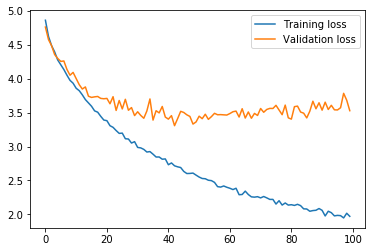

In [20]:
# Plot the training and validation losses
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [10]:
# Test function is also referenced from cifar exercise.
# After multiple iterations, the architecture of model was selected, making sure the accuracy is > 10%

def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(tqdm(loaders['test'])):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [22]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)


Test Loss: 3.344036


Test Accuracy: 22% (187/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [11]:
## TODO: Specify data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(valid_data, batch_size=16)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16)

loaders_transfer = {'train': train_loader, 'valid': val_loader, 'test': test_loader}

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [12]:
## TODO: Specify model architecture
# VGG16 provided accuracy of 63%
# VGG19_BN provided accuracy of 71%
# Resnet50 provided accuracy of 67%

# Working with VGG16 and VGG19 was very similar, hence same code is used.
model_transfer = models.vgg19_bn(pretrained=True)
for param in model_transfer.features.parameters():
    param.requires_grad = False

n_inputs = model_transfer.classifier[6].in_features
last_layer = nn.Linear(n_inputs, 133)
model_transfer.classifier[6] = last_layer

# For Resnet50
# Referenced from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
# model_transfer = models.resnet101(pretrained=True)
# num_ftrs = model_transfer.fc.in_features
# model_transfer.fc = nn.Linear(num_ftrs, 133)

In [13]:
if use_cuda:
    model_transfer = model_transfer.cuda()
    
print(model_transfer)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 
Here I have tested with three different pre-trained models:
* VGG16
* VGG19 with Batch Normalization
* Resnet50

Working with VGG16 and VGG19:  
Similar to transfer learning exercise during lesson, we use param.requires_grad to False to freeze the weights and then change the last fully connected layer to give 133 outputs.

Working with resnet50:  
Referenced from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html, we get the model and replace the fc layer which is the last layer to get 133 outputs.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [14]:
import torch.optim as optim

criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.parameters(), lr=0.0003)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [15]:
# train the model
model_transfer = train(50, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 3.037204 	Validation Loss: 1.679220
Saving model.  Validation loss:... inf --> 1.6792198419570923



Epoch: 2 	Training Loss: 2.009161 	Validation Loss: 1.468052
Saving model.  Validation loss:... 1.6792198419570923 --> 1.4680523872375488



Epoch: 3 	Training Loss: 1.861463 	Validation Loss: 1.429525
Saving model.  Validation loss:... 1.4680523872375488 --> 1.4295248985290527



Epoch: 4 	Training Loss: 1.776484 	Validation Loss: 1.330667
Saving model.  Validation loss:... 1.4295248985290527 --> 1.3306671380996704



Epoch: 5 	Training Loss: 1.746353 	Validation Loss: 1.256913
Saving model.  Validation loss:... 1.3306671380996704 --> 1.2569127082824707



Epoch: 6 	Training Loss: 1.676152 	Validation Loss: 1.141520
Saving model.  Validation loss:... 1.2569127082824707 --> 1.141520380973816



Epoch: 7 	Training Loss: 1.695643 	Validation Loss: 1.250400


Epoch: 8 	Training Loss: 1.621603 	Validation Loss: 1.192807


Epoch: 9 	Training Loss: 1.620263 	Validation Loss: 1.070501
Saving model.  Validation loss:... 1.141520380973816 --> 1.0705012083053589



Epoch: 10 	Training Loss: 1.601074 	Validation Loss: 1.129965


Epoch: 11 	Training Loss: 1.546939 	Validation Loss: 1.159518


Epoch: 12 	Training Loss: 1.550391 	Validation Loss: 1.118298


Epoch: 13 	Training Loss: 1.535675 	Validation Loss: 1.061577
Saving model.  Validation loss:... 1.0705012083053589 --> 1.0615769624710083



Epoch: 14 	Training Loss: 1.526622 	Validation Loss: 1.168549


Epoch: 15 	Training Loss: 1.540657 	Validation Loss: 1.216250


Epoch: 16 	Training Loss: 1.538941 	Validation Loss: 1.131519


Epoch: 17 	Training Loss: 1.549520 	Validation Loss: 1.134180


Epoch: 18 	Training Loss: 1.562492 	Validation Loss: 1.131093


Epoch: 19 	Training Loss: 1.508793 	Validation Loss: 1.197392


Epoch: 20 	Training Loss: 1.530734 	Validation Loss: 1.084480


Epoch: 21 	Training Loss: 1.481030 	Validation Loss: 1.098299


Epoch: 22 	Training Loss: 1.451339 	Validation Loss: 1.067502


Epoch: 23 	Training Loss: 1.541714 	Validation Loss: 1.143356


Epoch: 24 	Training Loss: 1.499577 	Validation Loss: 1.106151


Epoch: 25 	Training Loss: 1.478692 	Validation Loss: 1.057226
Saving model.  Validation loss:... 1.0615769624710083 --> 1.0572264194488525



Epoch: 26 	Training Loss: 1.542871 	Validation Loss: 1.054658
Saving model.  Validation loss:... 1.0572264194488525 --> 1.0546581745147705



Epoch: 27 	Training Loss: 1.516812 	Validation Loss: 1.092106


Epoch: 28 	Training Loss: 1.562202 	Validation Loss: 1.184948


Epoch: 29 	Training Loss: 1.519461 	Validation Loss: 1.120148


Epoch: 30 	Training Loss: 1.495315 	Validation Loss: 1.061711


Epoch: 31 	Training Loss: 1.559547 	Validation Loss: 1.071684


Epoch: 32 	Training Loss: 1.505049 	Validation Loss: 1.010341
Saving model.  Validation loss:... 1.0546581745147705 --> 1.0103408098220825



Epoch: 33 	Training Loss: 1.518320 	Validation Loss: 1.109681


Epoch: 34 	Training Loss: 1.524848 	Validation Loss: 0.997049
Saving model.  Validation loss:... 1.0103408098220825 --> 0.9970489144325256



Epoch: 35 	Training Loss: 1.527315 	Validation Loss: 1.083859


Epoch: 36 	Training Loss: 1.502634 	Validation Loss: 1.034071


Epoch: 37 	Training Loss: 1.471068 	Validation Loss: 1.069054


Epoch: 38 	Training Loss: 1.509765 	Validation Loss: 1.044324


Epoch: 39 	Training Loss: 1.510282 	Validation Loss: 1.057874


Epoch: 40 	Training Loss: 1.504097 	Validation Loss: 1.121001


Epoch: 41 	Training Loss: 1.507775 	Validation Loss: 0.996506
Saving model.  Validation loss:... 0.9970489144325256 --> 0.9965061545372009



Epoch: 42 	Training Loss: 1.555737 	Validation Loss: 1.147303


Epoch: 43 	Training Loss: 1.552690 	Validation Loss: 1.012138


Epoch: 44 	Training Loss: 1.504928 	Validation Loss: 0.966663
Saving model.  Validation loss:... 0.9965061545372009 --> 0.9666628837585449



Epoch: 45 	Training Loss: 1.535430 	Validation Loss: 1.061778


Epoch: 46 	Training Loss: 1.582436 	Validation Loss: 1.101235


Epoch: 47 	Training Loss: 1.564503 	Validation Loss: 1.133262


Epoch: 48 	Training Loss: 1.562827 	Validation Loss: 1.153301


Epoch: 49 	Training Loss: 1.561016 	Validation Loss: 1.099826


Epoch: 50 	Training Loss: 1.541968 	Validation Loss: 1.078129



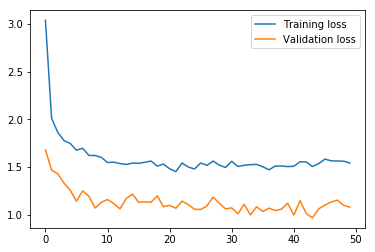

In [16]:
import matplotlib.pyplot as plt
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [17]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)


Test Loss: 1.116130


Test Accuracy: 71% (601/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [18]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
data_transfer = {}
data_transfer['train'] = train_data
class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    img = Image.open(img_path)

    transform = transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], 
                                 [0.229, 0.224, 0.225])
            ])
    img_tensor = transform(img)
    
    # reshaping to include batch size
    img_tensor = img_tensor.view(1, img_tensor.shape[0], img_tensor.shape[1], img_tensor.shape[2])
    
    prediction = model_transfer(img_tensor.cuda())
    class_idx = torch.argmax(prediction).item()
    
    return class_names[class_idx]

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [19]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def display(img, top_text, bottom_text):
    plt.imshow(img)
    plt.tight_layout()
    plt.gcf().text(0.25, 1, top_text, fontsize=12)
    plt.gcf().text(0.25, 0, bottom_text, fontsize=12)
    plt.xticks([]),plt.yticks([])
    plt.show()

def run_app(img_path):
    img = Image.open(img_path)
    
    ## handle cases for a human face, dog, and neither
    if (face_detector(img_path)):
        top_text = "Face of human detected"
        bottom_text = "Dog breed resembled in face: {}".format(predict_breed_transfer(img_path))
    elif(dog_detector(img_path)):
        top_text = "Dog detected"
        bottom_text = "Breed of the dog is: {}".format(predict_breed_transfer(img_path))
    else:
        top_text = "Neither dog, nor human detected"
        bottom_text = "Please try another image"
    display(img, top_text, bottom_text)

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)
* Hyper Parameter Tunning with Early Stopping:  
Early stopping can be done if we see that the model is not able to get better after 10-20 epochs. This will save us time and we should be able to use varying number of hyper-parameters.
* Dynamic Learning Rates and momentum:  
We can dynamically change the learning rate while training, once we observe that the model is stuck, we can change the value of learning rate and that might be able to get us over the hump of local minima
* Rules besides model:  
Sometimes, besides just looking at an image, we need to get other information as well, like the height of dogs, length of their ears, shape of their face to get a better understanding of the breed.
* Bigger Model:  
I have been using my personal PC and graphics card on it to train the model, for whatever reason, I was not able to use bigger resnet models. That, theorotically, might have increased my accuracy.

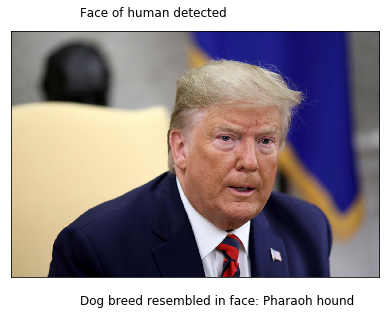

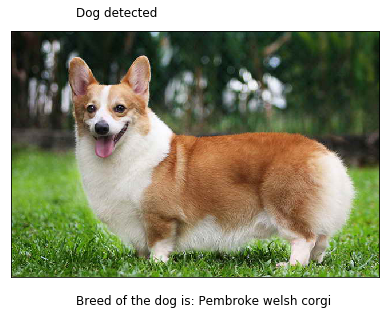

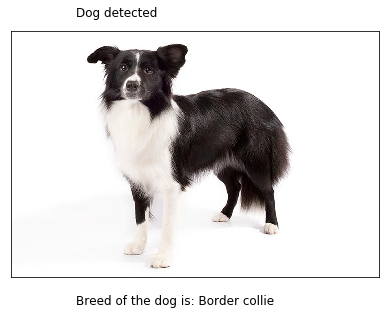

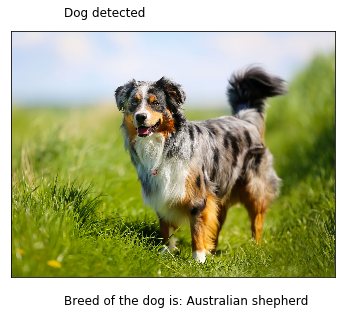

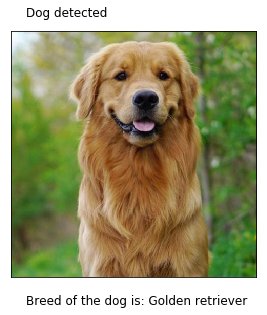

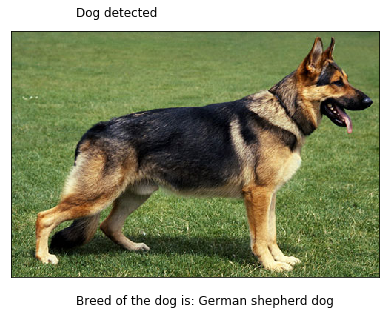

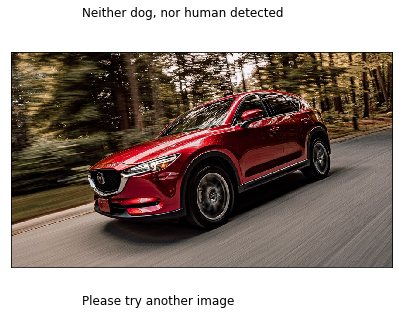

In [33]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for filename in os.listdir(parent_path):
    if filename.endswith('.jpg') or filename.endswith('.jpeg'):
        run_app('TestImages/' + filename)